# CW 04 part 1

In [224]:
import numpy as np
import matplotlib.pyplot as plt

In [225]:
def angular_spectrum_propagation_free_space(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U1  : the propagated field

    Implemented according to: 
    Matsushima, Kyoji, and Tomoyoshi Shimobaba. 
    "Band-limited angular spectrum method for numerical simulation of free-space propagation in far and near fields." 
    Optics express 17.22 (2009): 19662-19673.
    """

    # Get the shape of the original array
    original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2
    # Create a new array filled with zeros with the target shape
    U0_padded = np.zeros((original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype)
    # Place the original array in the center of the new array
    U0_padded[pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0
    
    # Get array size
    ny, nx = U0_padded.shape
    # Wave number
    k = 2 * np.pi / wvl 

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)

    Delta_uy =  1 / (ny * dx)
    Delta_ux =  1 / (nx * dx)
    u_limity = 1 / (np.sqrt((2 * Delta_uy * z)**2 + 1) * wvl)
    u_limitx = 1 / (np.sqrt((2 * Delta_ux * z)**2 + 1) * wvl)
    H_limit = W = ((FY**2 / u_limity**2 + FX**2 * wvl**2) < 1) * ((FX**2 / u_limitx**2 + FY**2 * wvl**2) < 1)
    # Kernel
    H = np.exp(1j * k * z * np.sqrt(0j + 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # propagate
    U1_padded = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(np.fft.ifftshift(U0_padded)) * H * H_limit))
    # extract to initial size
    U1 = U1_padded[pad_height:pad_height + original_height, pad_width:pad_width + original_width]
          
    return U1


# Box Through lens


1. Propagate a rectangular aperture with diameter `10µm`. Propagate it with `dx=1µm` and wavelength `633nm` over a distance `1mm` to a lens.
The lens has a focal length of 1mm.  Model the lens as thin transparency. Use `N=500` for each dimension and a total array size of `500µm` in each dimension.
Propagate after the lens for `1mm` further. What do you observe? Does this match your expectations? Plot the amplitude of the final field, not intensity.

2. In class we discovered the same operation can be described with a Scaled Fourier Transform. Can you achieve the same result just with an FFT. What is difference to the solution obtained in part 1.

## Solution 1

In [226]:
U0 = np.zeros((500, 500))
U0[250 - 5:250+5,250-5:250 + 5] = 1

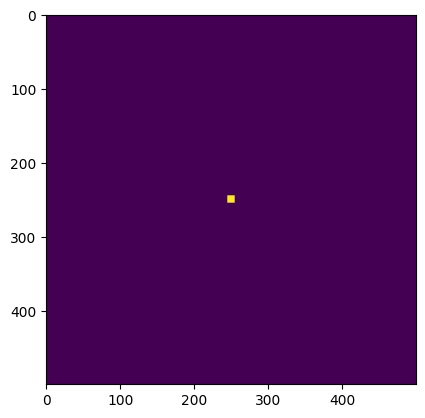

In [237]:
plt.imshow(np.abs(U0))

In [227]:
x = np.linspace(-250e-6, 250e-6, 500, endpoint=False)
y = x
X, Y = np.meshgrid(x,y)

In [228]:
k = 2 * np.pi / 633e-9

In [247]:
lens = np.exp(-1j * k / 2 / 1e-3 * (X**2 + Y**2))

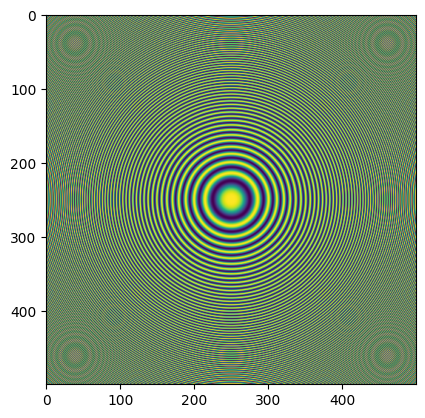

In [248]:
plt.imshow(np.real(lens))

In [246]:
prop = lambda U: angular_spectrum_propagation_free_space(U, 633e-9, 1e-6, 1e-3)

In [232]:
U_final = prop(lens * prop(U0))

In [233]:
633e-9 * 1e-3 * 500 / (500*1e-6)**2 

1.266

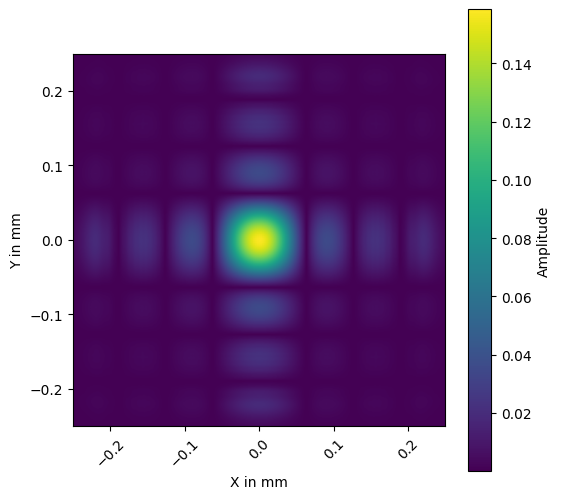

In [234]:
# Plot
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(U_final), extent=[x.min() * 1000, x.max() * 1000, y.min() * 1000, y.max() * 1000])
plt.colorbar(label="Amplitude")
plt.xlabel("X in mm")
plt.ylabel("Y in mm")
plt.xticks(rotation=45)
plt.grid(False)

## Solution 2

In [235]:
magnification = 633e-9 * 500 * 1e-3 / 500e-6**2 

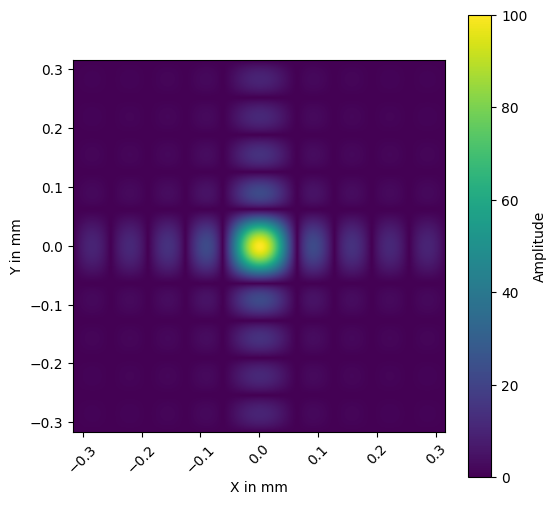

In [236]:
U_fft = np.abs(np.fft.fftshift(np.fft.fft2(U0)**1))

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(U_fft), extent=[x.min() * 1000 * magnification, x.max() * 1000 * magnification, y.min() * 1000 * magnification, y.max() * 1000 * magnification])
plt.colorbar(label="Amplitude")
plt.xlabel("X in mm")
plt.ylabel("Y in mm")
plt.xticks(rotation=45)
plt.grid(False)